# BSPF Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from functions.compute_linear_regression import __compute_linear_regression

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['path_to_figs'] = data_path+"BSPF/figures/"

config['catalog'] = ""

config['save'] = False

config['translation_type'] = "ACC"

## Load Data

In [5]:
# data_amax_disp = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_amax_disp.pkl")

# data_snr = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_snr_disp.pkl")

In [23]:
data_amax = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_amax_{config['translation_type']}.pkl")

data_snr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_snr_{config['translation_type']}.pkl")

data_adr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_adr_{config['translation_type']}.pkl")

In [24]:
data_amax_cosum_6 = data_amax[data_amax.CoincidenceSum == 6]

data_snr_cosum_6 = data_snr[data_snr.CoincidenceSum == 6]

## Modify Data

Filter data

In [25]:
## reject nan values
print(f" AMAX:  all: {data_amax.origin.size} no_nan: {data_amax.origin.dropna().shape[0]}")
data_amax.origin.dropna(inplace=True)

print(f" SNR:  all: {data_snr.origin.size} no_nan: {data_snr.origin.dropna().shape[0]}")
data_snr.origin.dropna(inplace=True)

print(f" CoSum6:  all: {data_amax_cosum_6.origin.size} no_nan: {data_amax_cosum_6.origin.dropna().shape[0]}")
data_amax_cosum_6.origin.dropna(inplace=True)

 AMAX:  all: 225 no_nan: 225
 SNR:  all: 225 no_nan: 225
 CoSum6:  all: 131 no_nan: 131


/tmp/ipykernel_1176678/4006315242.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amax_cosum_6.origin.dropna(inplace=True)


In [26]:
# ## reject all magnitude types not ml
# nn = [mm for mm in data_amax.Mag_type if mm != "ml"]

# data_amax_disp = data_amax[data_amax.Mag_type == "ml"]
# data_snr = data_snr[data_snr.Mag_type == "ml"]

# print(f"\n -> rejected {len(nn)} events: {nn}")

In [27]:
data_snr_cosum_6.shape, data_amax_cosum_6.shape

((131, 27), (131, 27))

## Plots

In [28]:
def __makeplot(data1, data2, data3, data4):

    import matplotlib

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    font=14

    cmap = plt.get_cmap("viridis", 9)

    # dat = np.log10(data4.BSPF__N_snr)
    dat = np.log10(data4.PFO_10_Z_snr)


    ax.scatter(data1.Hdistance_km, data1.Magnitude, s=30, color="grey", zorder=1, label=f"all (N={len(data1)})")

    cax = ax.scatter(data2.Hdistance_km, data2.Magnitude, s=50, lw=0.5, edgecolors="k",
                     c=dat, cmap=cmap, zorder=2, label=f"CoSum6 (N={len(data2)})", vmin=round(min(dat),1), vmax=4.5)

    ax.grid(ls="--", color="grey", alpha=0.6, zorder=0,which="both")
    ax.legend(loc=4, fontsize=font)

    ax.set_ylabel("Magnitude", fontsize=font)
    ax.set_xlabel("Hypocenter Distance (km)", fontsize=font)

    ax.set_xscale("log")
    ax.set_xlim(left=10)

    cbar = plt.colorbar(cax, pad=0.02)
    cbar.set_label(r"log$_{10}$(signal-to-noise ratio)", fontsize=font)
#     cbar.set_clim(0,4)

    ax.set_xticks([10, 20, 30, 40, 50, 100])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.show()

# __makeplot(data_amax, data_amax_cosum_6, data_snr, data_snr_cosum_6)

## Magnitude Scale 

$M_L = log_{10} (A_{max}) + 1.11 log_{10} (R) + 0.00189 R - 2.09$   (adopted local magnitude scale)

with $R$ = hypocentral distance in km and $A_{max}$ = maximal amplitude in nm

In [29]:
def __ml(amax, hdist):
    return np.log10(amax) + 1.11*np.log10(hdist) + 0.00189*hdist -2.09

In [30]:
# ## reject nan values
# print(f" AMAX:  all: {data_amax.origin.size} no_nan: {data_amax.dropna().shape[0]}")
# data_amax.dropna(inplace=True)

In [31]:
# ## reject all magnitude types not ml
# nn = [mm for mm in data_amax.Mag_type if mm != "ml"]
# data_amax = data_amax[data_amax.Mag_type == "ml"]
# print(f"\n -> rejected {len(nn)} events: {nn}")

In [32]:
mm_z = __ml(data_amax.PFO_10_Z_amax*1e6, data_amax.Hdistance_km)
mm_n = __ml(data_amax.PFO_10_N_amax*1e6, data_amax.Hdistance_km)
mm_e = __ml(data_amax.PFO_10_E_amax*1e6, data_amax.Hdistance_km)

mm_t = __ml(data_amax.PFO_10_T_amax*1e6, data_amax.Hdistance_km)
mm_r = __ml(data_amax.PFO_10_R_amax*1e6, data_amax.Hdistance_km)


In [33]:
def __makeplot_magnitude_comparison():

    fig, ax = plt.subplots(1,3, figsize=(15,4))

    ax[0].scatter(hdist, mm, color='k', zorder=3)
    ax[0].scatter(hdist, mm_z, s=15, zorder=3, label="Z", edgecolors="tab:orange", color="tab:orange", alpha=0.7)
    ax[0].scatter(hdist, mm_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0].scatter(hdist, mm_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0].grid(zorder=0, alpha=0.4)
    ax[0].legend(loc=4)

    ax[0].set_xlabel(r"log$_{10}$( Hypocentral Distance ) (km)")
    ax[0].set_ylabel("Magnitude")

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mm, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1].hist(mm, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    ax[1].hist(mm_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1].hist(mm_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.5, fill=False, align="mid", label="N")
    ax[1].hist(mm_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.3, fill=False, align="mid", label="E")
    ax[1].set_xticks(bars)
    # ax[1].set_xticks(bars+dbars/2)
    # ax[1].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1].legend(loc=1)
    ax[1].grid(zorder=0, alpha=0.4)

    ax[1].set_xlabel(r"M$_L$")
    ax[1].set_ylabel("Total Number")

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[2].hist(diff_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[2].hist(diff_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[2].legend(loc=1)
    ax[2].grid(zorder=0, alpha=0.4)

    ax[2].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[2].set_ylabel("Total Number")

    plt.show();

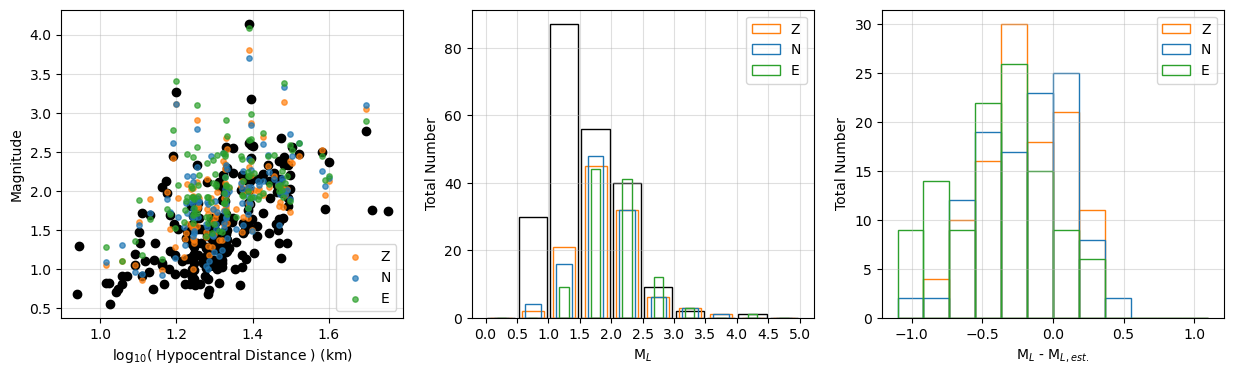

In [35]:
x_events = range(len(data_amax))

hdist = np.log10(data_amax.Hdistance_km)

mm = data_amax.Magnitude

diff_z, diff_n, diff_e = mm-mm_z, mm-mm_n, mm-mm_e

__makeplot_magnitude_comparison()

## Fitting Translation Data

In [36]:
def __ml_fit(X, a, b, c):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist) + b*hdist - c

In [37]:
def __predict_local_amplitude_ml(X):
    mag, hdist = X
    return 10**( mag - 1.11*np.log10(hdist) - 0.00189*hdist +  2.09)

In [38]:
def __predict_local_amplitude(X, a, b, c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist + c )

In [39]:
## select amplitude data
amax_n = data_amax_cosum_6.PFO_10_N_amax*1e9
amax_e = data_amax_cosum_6.PFO_10_E_amax*1e9

## select hypocentral distances and magnitudes
hdist = data_amax_cosum_6.Hdistance_km
mag = data_amax_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 2.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n N_trans:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_trans:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e

## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])

ValueError: array must not contain infs or NaNs

NameError: name 'syn_data_n' is not defined

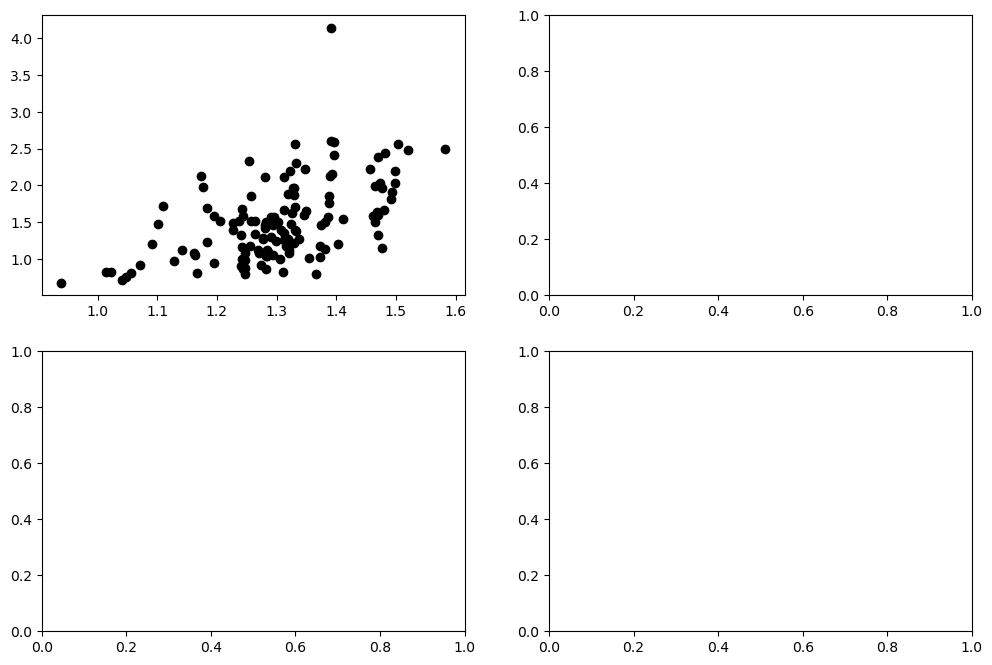

In [40]:
def __makeplot_magnitude_comparison2():

    fig, ax = plt.subplots(2,2, figsize=(12,8))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, color='k', zorder=3)
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$(R) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.7)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.7)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$(A$_{max}$) (nm)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0,5+dbars,dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    # ax[1,1].hist(mag_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               # color="tab:orange", edgecolor="tab:orange", rwidth=0.7, fill=False, align="mid", label="Z")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].set_xticks(bars)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________


    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)

    # ax[2].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")



    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}")

    plt.show();
    return fig

fig = __makeplot_magnitude_comparison2()

# fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_translationsNE.png", format="png", dpi=200, bbox_inches='tight')

## Fitting Rotation Data

In [41]:
## select amplitude data
amax_n = data_amax_cosum_6.BSPF__N_amax
amax_e = data_amax_cosum_6.BSPF__E_amax
amax_z = data_amax_cosum_6.BSPF__Z_amax

## select hypocentral distances and magnitudes
hdist = data_amax_cosum_6.Hdistance_km
mag = data_amax_cosum_6.Magnitude

## perform data fitting
popt_n, pcov_n = curve_fit(__ml_fit, (amax_n, hdist), mag, p0=(1., 0.001, 2.))
popt_e, pcov_e = curve_fit(__ml_fit, (amax_e, hdist), mag, p0=(1., 0.001, 2.))
popt_z, pcov_z = curve_fit(__ml_fit, (amax_z, hdist), mag, p0=(1., 0.001, 2.))

## output the new laws
print(f"\n N_rot:   Ml = log10(Amax) + {popt_n[0]:.2f} log10(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}")
print(f"\n E_rot:   Ml = log10(Amax) + {popt_e[0]:.2f} log10(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}")
print(f"\n Z_rot:   Ml = log10(Amax) + {popt_z[0]:.2f} log10(R) + {popt_z[1]:.5f} R + {popt_z[2]:.2f}")

## generate synthetic magnitudes
syn_data_e = __ml_fit((amax_e, hdist), popt_e[0], popt_e[1], popt_e[2])
syn_data_n = __ml_fit((amax_n, hdist), popt_n[0], popt_n[1], popt_n[2])
syn_data_z = __ml_fit((amax_z, hdist), popt_z[0], popt_z[1], popt_z[2])

## compute differences of magnitudes and synthetics
diff_syn_n = mag-syn_data_n
diff_syn_e = mag-syn_data_e
diff_syn_z = mag-syn_data_z


## compute synthetic maximal amplitudes
amax_syn = __predict_local_amplitude_ml((mag, hdist))
amax_syn_n = __predict_local_amplitude((mag, hdist), popt_n[0], popt_n[1], popt_n[2])
amax_syn_e = __predict_local_amplitude((mag, hdist), popt_e[0], popt_e[1], popt_e[2])
amax_syn_z = __predict_local_amplitude((mag, hdist), popt_z[0], popt_z[1], popt_z[2])


 N_rot:   Ml = log10(Amax) + -1.59 log10(R) + 0.08561 R + -7.52

 E_rot:   Ml = log10(Amax) + -0.26 log10(R) + 0.05594 R + -6.67

 Z_rot:   Ml = log10(Amax) + -0.75 log10(R) + 0.06922 R + -7.12


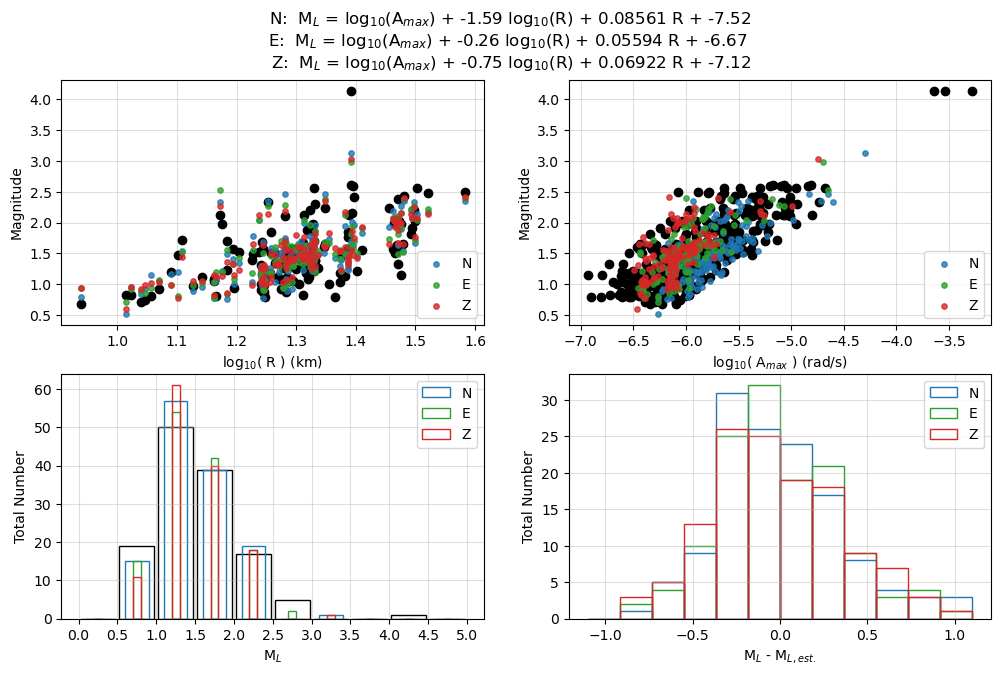

In [42]:
def __makeplot_magnitude_comparison3():

    fig, ax = plt.subplots(2, 2, figsize=(12, 7))

    ## ______________________________________________________________

    ax[0,0].scatter(np.log10(hdist), mag, zorder=3, color="black")
    ax[0,0].scatter(np.log10(hdist), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,0].scatter(np.log10(hdist), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)
    ax[0,0].scatter(np.log10(hdist), syn_data_z, s=15, zorder=3, label="Z", edgecolors="tab:red", color="tab:red", alpha=0.8)

    ax[0,0].grid(zorder=0, alpha=0.4)
    ax[0,0].legend(loc=4)

    ax[0,0].set_xlabel(r"log$_{10}$( R ) (km)")
    ax[0,0].set_ylabel("Magnitude")


    ## ______________________________________________________________

    ax[0,1].scatter(np.log10(amax_syn_n), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_e), mag, color='k', zorder=3)
    ax[0,1].scatter(np.log10(amax_syn_z), mag, color='k', zorder=3)

    ax[0,1].scatter(np.log10(amax_n), syn_data_n, s=15, zorder=3, label="N", edgecolors="tab:blue", color="tab:blue", alpha=0.8)
    ax[0,1].scatter(np.log10(amax_e), syn_data_e, s=15, zorder=3, label="E", edgecolors="tab:green", color="tab:green", alpha=0.8)
    ax[0,1].scatter(np.log10(amax_z), syn_data_z, s=15, zorder=3, label="Z", edgecolors="tab:red", color="tab:red", alpha=0.8)

    ax[0,1].grid(zorder=0, alpha=0.4)
    ax[0,1].legend(loc=4)

    ax[0,1].set_xlabel(r"log$_{10}$( A$_{max}$ ) (rad/s)")
    ax[0,1].set_ylabel("Magnitude")


    ## ______________________________________________________________

    dbars = 0.5
    bars = np.arange(0, 5 + dbars, dbars)

    # labels, counts = np.unique(mag, return_counts=True)
    # ax[1].bar(labels, counts, align='center', width=0.5)

    ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="k", rwidth=0.9, fill=False, align="mid")
    ax[1,0].hist(syn_data_n, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N")
    ax[1,0].hist(syn_data_e, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:green", edgecolor="tab:green", rwidth=0.2, fill=False, align="mid", label="E")
    ax[1,0].hist(syn_data_z, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
               color="tab:red", edgecolor="tab:red", rwidth=0.2, fill=False, align="mid", label="Z")

    ax[1,0].set_xticks(bars)
    # ax[1,0].set_xticks(bars+dbars/2)
    # ax[1,0].set_xticklabels([f"{b}-{b+dbars}" for b in bars], rotation=60)

    ax[1,0].legend(loc=1)
    ax[1,0].grid(zorder=0, alpha=0.4)

    ax[1,0].set_xlabel(r"M$_L$")
    ax[1,0].set_ylabel("Total Number")


    ## ______________________________________________________________

    lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
    dbars2 = 0.2
    bars2 = np.arange(-lim, lim+dbars2, dbars2)
    # ax[1,1].hist(diff_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
    #            color="tab:orange", edgecolor="tab:orange", rwidth=1, fill=False, align="mid", label="Z")
    ax[1,1].hist(diff_syn_n, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N")
    ax[1,1].hist(diff_syn_e, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:green", edgecolor="tab:green", rwidth=1, fill=False, align="mid", label="E")
    ax[1,1].hist(diff_syn_z, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
               color="tab:red", edgecolor="tab:red", rwidth=1, fill=False, align="mid", label="Z")

    ax[1,1].legend(loc=1)
    ax[1,1].grid(zorder=0, alpha=0.4)

    ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
    ax[1,1].set_ylabel("Total Number")


    ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
    law1 = f"{ml_str} = {log10_str}({amax_str}) + {popt_n[0]:.2f} {log10_str}(R) + {popt_n[1]:.5f} R + {popt_n[2]:.2f}"
    law2 = f"{ml_str} = {log10_str}({amax_str}) + {popt_e[0]:.2f} {log10_str}(R) + {popt_e[1]:.5f} R + {popt_e[2]:.2f}"
    law3 = f"{ml_str} = {log10_str}({amax_str}) + {popt_z[0]:.2f} {log10_str}(R) + {popt_z[1]:.5f} R + {popt_z[2]:.2f}"
    plt.suptitle(f" N:  {law1}  \nE:  {law2}  \nZ:  {law3}")

    plt.show();
    return fig

fig = __makeplot_magnitude_comparison3()

fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_rotationsNEZ.png", format="png", dpi=200, bbox_inches='tight')

## Single Law for horizontals

In [43]:
# ## select amplitude data
# amax_H = data_amax_cosum_6.BSPF__N_amax
# amax_H = np.append(amax, data_amax_cosum_6.BSPF__E_amax)

# amax_Z = data_amax_cosum_6.BSPF__Z_amax

# ## select hypocentral distances and magnitudes
# hdist = data_amax_cosum_6.Hdistance_km
# hdist = np.append(hdist, data_amax_cosum_6.Hdistance_km)

# mag = data_amax_cosum_6.Magnitude
# mag = np.append(mag, data_amax_cosum_6.Magnitude)

# ## perform data fitting
# popt_H, pcov_H = curve_fit(__ml_fit, (amax, hdist), mag, p0=(1., 0.001, 2.))
# popt_Z, pcov_Z = curve_fit(__ml_fit, (amax, hdist), mag, p0=(1., 0.001, 2.))

# ## output the new laws
# print(f"\n rot:   Ml(H) = log10(Amax) + {popt_H[0]:.2f} log10(R) + {popt_H[1]:.5f} R + {popt_H[2]:.2f}")
# print(f"\n rot:   Ml(Z) = log10(Amax) + {popt_Z[0]:.2f} log10(R) + {popt_Z[1]:.5f} R + {popt_Z[2]:.2f}")

# ## generate synthetic magnitudes
# syn_data = __ml_fit((amax, hdist), popt_H[0], popt_H[1], popt_H[2])

# ## compute differences of magnitudes and synthetics
# diff_syn = mag-syn_data

# ## compute synthetic maximal amplitudes
# # amax_syn = __predict_local_amplitude_ml((mag, hdist))
# amax_syn = __predict_local_amplitude((mag, hdist), popt[0], popt[1], popt[2])


In [44]:
# def __makeplot_magnitude_comparison4():

#     fig, ax = plt.subplots(2,2, figsize=(12,7))

#     ## ______________________________________________________________

#     ax[0,0].scatter(np.log10(hdist), mag, color='k', zorder=3)
#     ax[0,0].scatter(np.log10(hdist), syn_data, s=15, zorder=3, label="N+E", edgecolors="tab:blue", color="tab:blue", alpha=0.7)

#     ax[0,0].grid(zorder=0, alpha=0.4)
#     ax[0,0].legend(loc=4)

#     ax[0,0].set_xlabel(r"log$_{10}$( R ) (km)")
#     ax[0,0].set_ylabel("Magnitude")

#     ## ______________________________________________________________

#     ax[0,1].scatter(np.log10(amax_syn), mag, color='k', zorder=3)
#     ax[0,1].scatter(np.log10(amax), syn_data, s=15, zorder=3, label="N+E", edgecolors="tab:blue", color="tab:blue", alpha=0.7)

#     ax[0,1].grid(zorder=0, alpha=0.4)
#     ax[0,1].legend(loc=4)

#     ax[0,1].set_xlabel(r"log$_{10}$( A$_{max}$ ) (rad/s)")
#     ax[0,1].set_ylabel("Magnitude")

#     ## ______________________________________________________________

#     dbars = 0.5
#     bars = np.arange(0,5+dbars,dbars)

#     # labels, counts = np.unique(mag, return_counts=True)
#     # ax[1].bar(labels, counts, align='center', width=0.5)

#     ax[1,0].hist(mag, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
#                color="k", rwidth=0.9, fill=False, align="mid")

#     ax[1,0].hist(syn_data, bins=int(len(bars)-1), density=False, histtype='bar', range=(min(bars), max(bars)),
#                color="tab:blue", edgecolor="tab:blue", rwidth=0.6, fill=False, align="mid", label="N+E")

#     ax[1,0].set_xticks(bars)

#     ax[1,0].legend(loc=1)
#     ax[1,0].grid(zorder=0, alpha=0.4)

#     ax[1,0].set_xlabel(r"M$_L$")
#     ax[1,0].set_ylabel("Total Number")


#     ## ______________________________________________________________

#     lim = round(max(max(abs(diff_z)), max(abs(diff_n)), max(abs(diff_e))),1)
#     dbars2 = 0.2
#     bars2 = np.arange(-lim, lim+dbars2, dbars2)

#     ax[1,1].hist(diff_syn, bins=len(bars2)-1, density=False, histtype='bar', range=(-lim, lim),
#                color="tab:blue", edgecolor="tab:blue", rwidth=1, fill=False, align="mid", label="N+E")


#     ax[1,1].legend(loc=1)
#     ax[1,1].grid(zorder=0, alpha=0.4)

#     ax[1,1].set_xlabel(r"M$_L$ - M$_{L, est.}$")
#     ax[1,1].set_ylabel("Total Number")

#     ml_str, log10_str, amax_str = r"M$_L$", r"log$_{10}$", r"A$_{max}$"
#     plt.suptitle(f" {ml_str} = {log10_str}({amax_str}) + {popt[0]:.2f} {log10_str}(R) + {popt[1]:.5f} R + {popt[2]:.2f}", y=0.94)

#     plt.show();
#     return fig

# fig = __makeplot_magnitude_comparison4()

# # fig.savefig(config['path_to_figs']+"BSPF_magnitudescales_modelallrotations.png", format="png", dpi=200, bbox_inches='tight')

## Minimal Amplitude

In [45]:
def __predict_local_magnitude(X, a, b, c):
    amp, hdist = X
    return np.log10(amp) + a*np.log10(hdist) + b*hdist - c

In [47]:

a_n, b_n, c_n = popt_n[0], popt_n[1], popt_n[2]
a_e, b_e, c_e = popt_e[0], popt_e[1], popt_e[2]
a_z, b_z, c_z = popt_z[0], popt_z[1], popt_z[2]


hdist = np.arange(1, 125+1, 1)
mag = np.arange(-1, 6.0+0.1, 0.1)

amax_syn_n = np.zeros((len(hdist), len(mag)))
amax_syn_e = np.zeros((len(hdist), len(mag)))
amax_syn_z = np.zeros((len(hdist), len(mag)))

for i, h in enumerate(hdist):
    for j, m in enumerate(mag):
        amax_syn_n[i, j] = __predict_local_amplitude((m, h), a_n, b_n, c_n)
        amax_syn_e[i, j] = __predict_local_amplitude((m, h), a_e, b_e, c_e)
        amax_syn_z[i, j] = __predict_local_amplitude((m, h), a_z, b_z, c_z)


In [48]:
bspf_e = data_amax_cosum_6.BSPF__E_amax
bspf_n = data_amax_cosum_6.BSPF__N_amax
bspf_z = data_amax_cosum_6.BSPF__Z_amax

bspf_mag = data_amax_cosum_6.Magnitude
bspf_hdist = data_amax_cosum_6.Hdistance_km

## blueSeis self-noise
limit = 20e-9  ## rad/s
mag_limit_n = __predict_local_magnitude((limit, hdist), popt_n[0], popt_n[1], popt_n[2])
mag_limit_e = __predict_local_magnitude((limit, hdist), popt_e[0], popt_e[1], popt_e[2])
mag_limit_z = __predict_local_magnitude((limit, hdist), popt_z[0], popt_z[1], popt_z[2])

In [49]:
def __makeplot():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(20)
    # cmap = mpl.colormaps['rainbow'].resampled(11)
    cmap.set_under('gray')


    amin_n, amax_n = min(amax_syn_n.reshape(1, amax_syn_n.size)[0]), max(amax_syn_n.reshape(1, amax_syn_n.size)[0])
    amin_e, amax_e = min(amax_syn_e.reshape(1, amax_syn_e.size)[0]), max(amax_syn_e.reshape(1, amax_syn_e.size)[0])
    amin_z, amax_z = min(amax_syn_z.reshape(1, amax_syn_z.size)[0]), max(amax_syn_z.reshape(1, amax_syn_z.size)[0])

    amin, amax = min(amin_n, amin_e, amin_z), max(amax_n, amax_e, amax_z)

    # lev = np.logspace(round(np.log10(amin),0), round(np.log10(amax),0), 10)
    lev = np.logspace(-12, 0, 20)
    lev_lbl = np.linspace(-12, 0, 20).astype(int)

    ax[0].scatter(bspf_mag, bspf_hdist, c=bspf_n, s=40, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                  norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    cb0 = ax[0].contourf(mag, hdist, amax_syn_n, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb1 = ax[1].scatter(bspf_mag, bspf_hdist, c=bspf_e, s=40, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    ax[1].contourf(mag, hdist, amax_syn_e, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb2 = ax[2].scatter(bspf_mag, bspf_hdist, c=bspf_z, s=40, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin_z, vmax=amax_z))
    ax[2].contourf(mag, hdist, amax_syn_z, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    ax[0].plot(mag_limit_n, hdist, color="tab:red", ls="--")
    ax[1].plot(mag_limit_e, hdist, color="tab:red", ls="--")
    ax[2].plot(mag_limit_z, hdist, color="tab:red", ls="--")

    for jj in range(3):
        ax[jj].set_xlim(-1, 6)
        ax[jj].set_ylim(1, 70)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='min')
    cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label("log10 ( max. Amplitude ) (rad/s)", labelpad=-50)

    ax[0].set_xlabel("Magnitude")
    ax[0].set_ylabel("Hypocentral Distance (km)")

    ax[1].set_xlabel("Magnitude")
    # ax[1].set_ylabel("Hypocentral Distance (km)")

    ax[0].set_title("BSPF-N")
    ax[0].set_title("BSPF-N")
    ax[1].set_title("BSPF-E")
    ax[2].set_title("BSPF-Z")

    plt.show();
    return fig

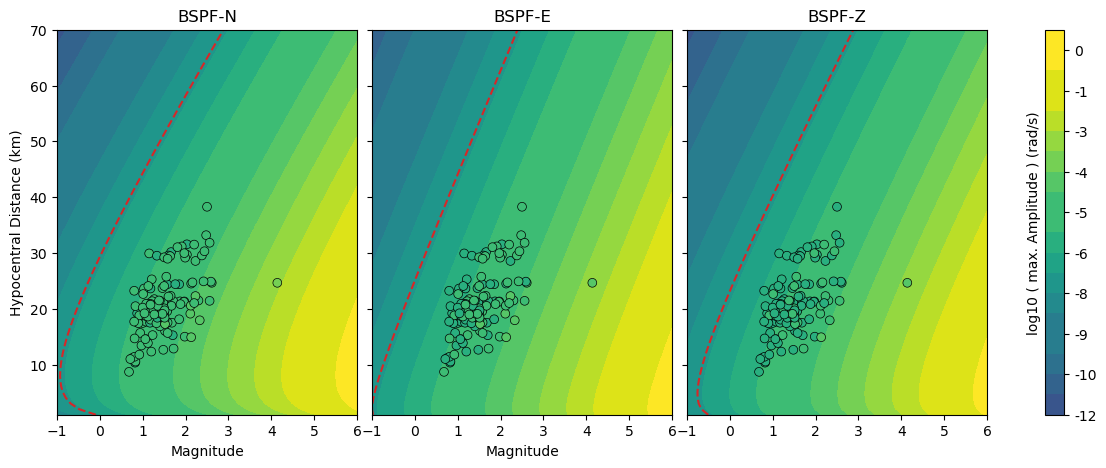

In [50]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+"BSPF_model_magnitudescale.png", format="png", dpi=200, bbox_inches='tight')